# Training transformer

## Import package

In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoModelForCausalLM, GPT2Config, set_seed
from transformers import Qwen2Model, Qwen2Config
from datasets import load_dataset
from typing import Dict, Any, Optional


In [2]:
set_seed(0)

In [3]:
from typing import List, Tuple, Union
import torch
from torch.utils.data import Dataset

class PixelSequenceDataset(Dataset):
    def __init__(self, data: List[List[int]], mode: str = "train"):
        self.data = data
        self.mode = mode
    
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, idx: int) -> Union[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        # Union - 多态，匹配多种类型
        '''
        train: return -> (input_ids, labels)
        dev: return -> (input_ids, labels)
        test: -> input_ids
        '''
        sequence = self.data[idx] # 拿出指定序号的色彩列
        # 注意这里的transformer训练特点
        if self.mode == "train":
            input_ids = torch.tensor(sequence[:-1], dtype = torch.long) # 用来输入decoder的是最后一个之前的pixel
            labels = torch.tensor(sequence[1:], dtype = torch.long) # 用来label的是除了第一个之外的label
            # 因为这里输入和输出都是固定长度的，所以不需要什么起始和终止，也不需要tokenizer
            return input_ids, labels
        elif self.mode == "dev":
            # 验证的话，后160像素用来验证
            input_ids = torch.tensor(sequence[:-160], dtype=torch.long)
            labels = torch.tensor(sequence[-160:], dtype=torch.long)
            return input_ids, labels
        elif self.mode == "test":
            # test的话就全拿走
            input_ids = torch.tensor(sequence, dtype=torch.long)
            return input_ids

        raise ValueError(f"Invalid mode: {self.mode}. Choose from 'train', 'dev', or 'test'.")
    
    
    

## download dataset

In [62]:
# Load the pokemon dataset from Hugging Face Hub
pokemon_dataset = load_dataset("lca0503/ml2025-hw4-pokemon")
# (index, 400, num_classes)

# Load the colormap from Hugging Face Hub
colormap = list(load_dataset("lca0503/ml2025-hw4-colormap")["train"]["color"])
# colarmap 是序号和颜色的对应表 (colar_classes, 3(rgb))

# Define number of classes
num_classes = len(colormap)

# Define batch size
batch_size = 32

# === Prepare Dataset and DataLoader for Training ===
train_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["train"]["pixel_color"], mode="train"
)
train_dataloader: DataLoader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# === Prepare Dataset and DataLoader for Validation ===
dev_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["dev"]["pixel_color"], mode="dev"
)
dev_dataloader: DataLoader = DataLoader(
    dev_dataset, batch_size=batch_size, shuffle=False
)

# === Prepare Dataset and DataLoader for Testing ===
test_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["test"]["pixel_color"], mode="test"
)
test_dataloader: DataLoader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

#train_test_dataset: PixelSequenceDataset = PixelSequenceDataset(
#    pokemon_dataset["train"]["pixel_color"], mode="dev"
#)
#train_test_dataloader: DataLoader = DataLoader(
#    train_test_dataset, batch_size = batch_size, shuffle = False
#)

print(num_classes)

167


In [5]:
def pixel_to_image(pixel_color: List[int], colormap: List[List[int]]) -> Image.Image:
    """
    Converts a list of pixel indices into a 20x20 RGB image using a colormap.

    Args:
        pixel_color (List[int]): A list of pixel indices representing colors.
        colormap (List[List[int]]): A list where each index maps to an RGB color [R, G, B].

    Returns:
        Image.Image: A PIL Image object representing the reconstructed image.
    """
    # Ensure the pixel_color list has at least 400 elements (pad with 0s if needed)
    while len(pixel_color) < 400:
        pixel_color.append(0)

    # Map pixel indices to actual RGB colors using the colormap
    pixel_data = [colormap[pixel] for pixel in pixel_color]

    # Convert to numpy array and reshape to 20x20x3 (RGB image)
    image_array = np.array(pixel_data, dtype=np.uint8).reshape(20, 20, 3)

    # Create a PIL Image from the array
    image = Image.fromarray(image_array)

    return image

def show_images(images: List[Image.Image]) -> None:
    """
    Displays a grid of up to 96 images using Matplotlib.

    Args:
        images (List[Image.Image]): A list of PIL Image objects to display.

    Returns:
        None
    """
    num_images = min(96, len(images))  # Limit to 96 images

    # Set up the figure size and grid layout (6 rows, 16 columns)
    fig, axes = plt.subplots(6, 16, figsize=(16, 6))
    axes = axes.flatten()  # Flatten to make iteration easier
    # 最多输出96张

    # Loop through images and display each one in the grid
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')  # Hide axis
        else:
            ax.axis('off')  # Hide unused subplots

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

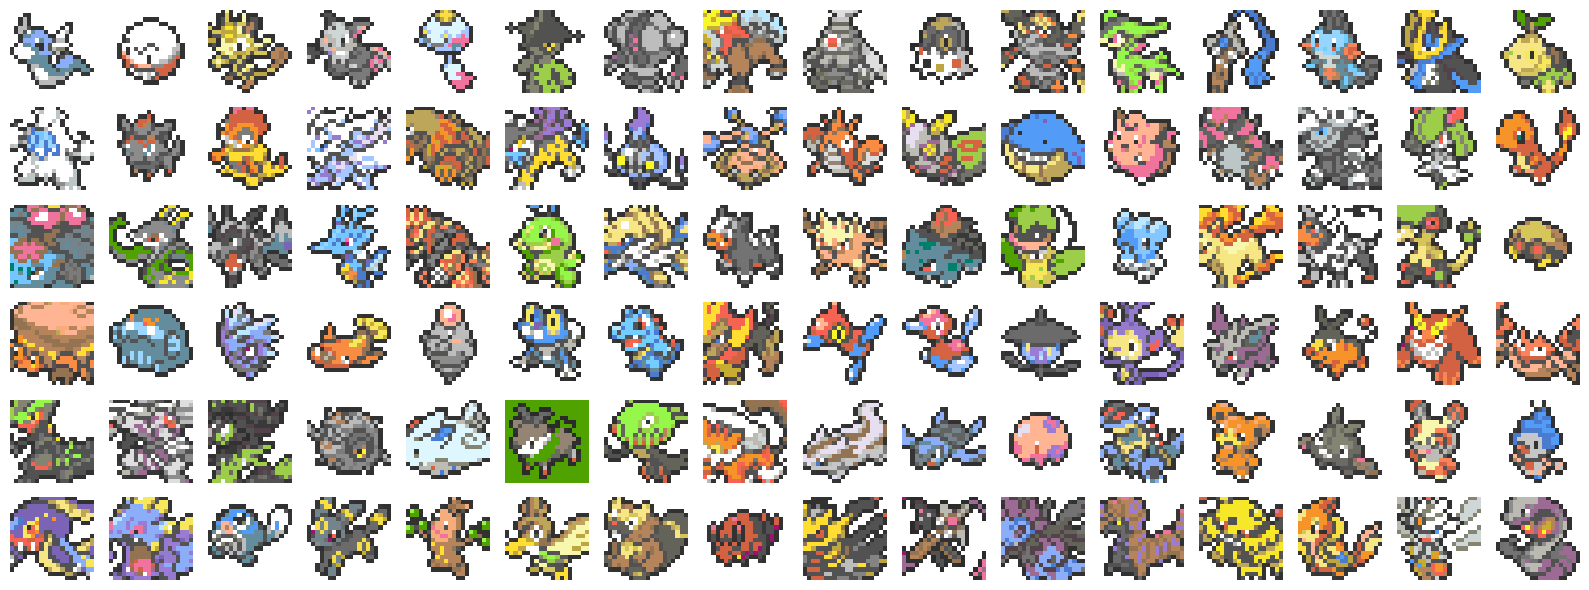

In [6]:
# Visualize train images
train_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["train"]]
show_images(train_images)

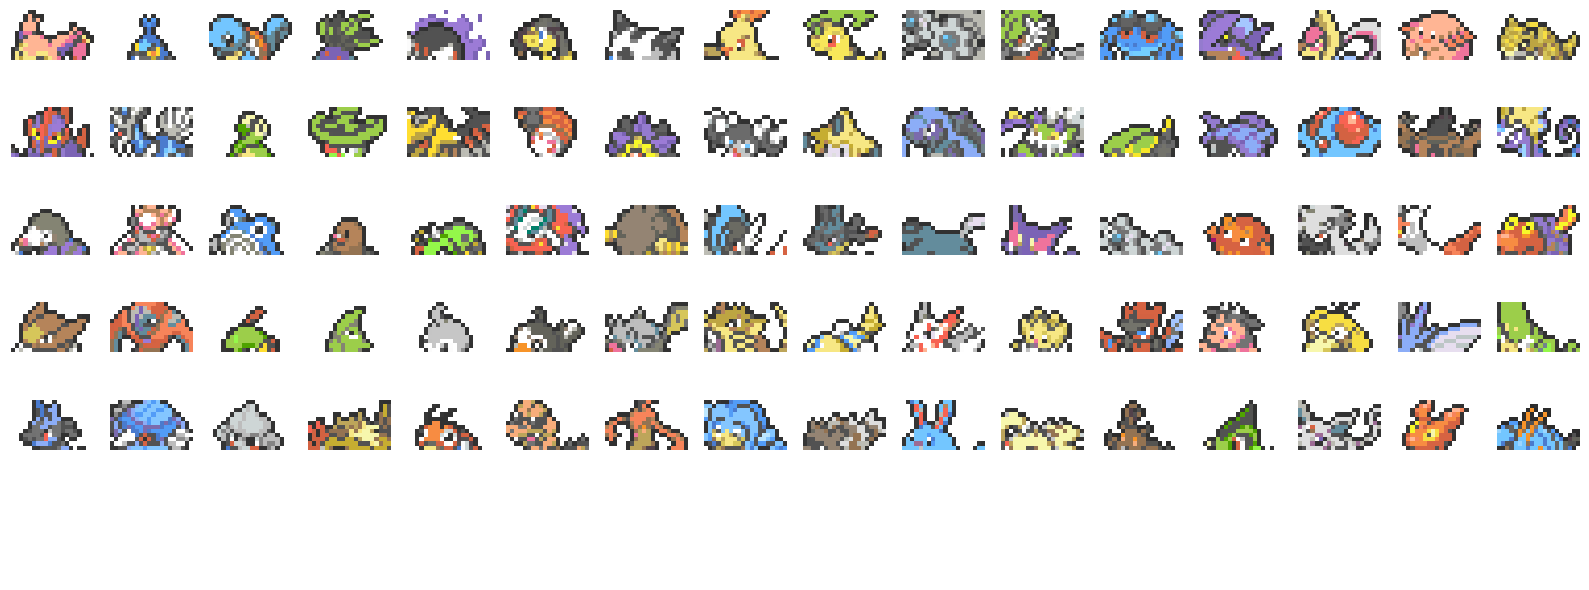

In [7]:
# Visualize test images
test_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["test"]]
show_images(test_images)

## prepare model

### Model Configuration
Here, we define the model configuration, including the architecture and key hyperparameters such as the number of attention heads, layers, embedding size, and more.
*   Hint 1: Adjust hyperparameters here for improved performance.
*   Hint 2: Experiment with different model architectures, such as Llama, Mistral, or Qwen, to enhance performance.
  * [LlamaConfig](https://huggingface.co/docs/transformers/model_doc/llama#transformers.LlamaConfig)
  * [MistralConfig](https://huggingface.co/docs/transformers/model_doc/mistral#transformers.MistralConfig)
  * [Qwen2Config](https://huggingface.co/docs/transformers/model_doc/qwen2#transformers.Qwen2Config)

In [56]:
# Define GPT-2 model configuration as a dictionary
gpt2_config = {
    "activation_function": "gelu_new",    # Activation function used in the model
    "architectures": ["GPT2LMHeadModel"],  # Specifies the model type
    "attn_pdrop": 0.1,            # Dropout rate for attention layers
    "embd_pdrop": 0.1,            # Dropout rate for embeddings
    "initializer_range": 0.02,        # Standard deviation for weight initialization
    "layer_norm_epsilon": 1e-05,       # Small constant to improve numerical stability in layer norm
    "model_type": "gpt2",           # Type of model
    "n_ctx": 400,               # Context size (maximum sequence length)
    "n_embd": 125,              # Embedding size
    # 也就是residual stream的size， dmodel
    "n_head": 4,               # Number of attention heads
    "n_layer": 4,              # Number of transformer layers
    "n_positions": 400,           # Maximum number of token positions
    # 最大位置数量，超过这个就没有位置编码了
    "resid_pdrop": 0.1,           # Dropout rate for residual connections
    "vocab_size": num_classes,       # Number of unique tokens in vocabulary
    "pad_token_id": None,          # Padding token ID (None means no padding token)
    "eos_token_id": None,          # End-of-sequence token ID (None means not explicitly defined)
}

qwen2_config = {
    "vocab_size" : num_classes,
    "hidden_size" : 125,
    "intermediate_size" : 512,
    "num_hidden_layers" : 4,
    "num_attention_heads" : 4,
    "num_key_value_heads" : 4,
    "max_position_embeddings" : 400,
    "attention_dropout" : 0.1,
    "model_type" : "qwen2"
    
}

# Load GPT-2 model configuration from dictionary
config = GPT2Config.from_dict(gpt2_config)

qwen2_config = Qwen2Config.from_dict(qwen2_config)

In [57]:
# Load the model using the configuration defined above
# model = AutoModelForCausalLM.from_config(config)
model = AutoModelForCausalLM.from_config(qwen2_config)

print(model)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Parameters: {trainable_params:,}")

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(167, 125)
    (layers): ModuleList(
      (0-3): 4 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=125, out_features=124, bias=True)
          (k_proj): Linear(in_features=125, out_features=124, bias=True)
          (v_proj): Linear(in_features=125, out_features=124, bias=True)
          (o_proj): Linear(in_features=124, out_features=125, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=125, out_features=512, bias=False)
          (up_proj): Linear(in_features=125, out_features=512, bias=False)
          (down_proj): Linear(in_features=512, out_features=125, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((125,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((125,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((125,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbedding()


## Train and Inference

### Training Arguments
Here, we define the number of epochs for training, the learning rate, the optimizer, and the loss function.
*   Hint 3: Adjust the number of epochs and learning rate here to improve performance.

In [63]:
# Training Parameters
epochs = 80                                # Number of training epochs
learning_rate = 1e-4                                 # Learning rate for optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")     # Check if CUDA is available for GPU
save_dir = "checkpoints_qwen2"                               # Directory to save model checkpoints

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()                          # Loss function for classification tasks
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1) # AdamW optimizer with weight decay

In [60]:
def save_model(model: torch.nn.Module, optimizer: torch.optim.Optimizer, epoch: int, loss: float, save_dir: str, filename: str = "best_model.pth") -> None:
    """
    Saves the model state, optimizer state, current epoch, and loss to a specified directory.

    Args:
        model (torch.nn.Module): The PyTorch model to be saved.
        optimizer (torch.optim.Optimizer): The optimizer whose state will be saved.
        epoch (int): The current epoch number (used for checkpointing).
        loss (float): The current loss value to track model performance.
        save_dir (str): The directory where the model checkpoint will be saved.
        filename (str, optional): The name of the file to save the model. Defaults to "best_model.pth".

    Returns:
        None
    """
    # Construct the full path for saving the model checkpoint
    save_path = os.path.join(save_dir, filename)

    # Save the model, optimizer state, and additional metadata (epoch and loss)
    torch.save({
        'epoch': epoch + 1,                # Save epoch + 1 for easier tracking
        'model_state_dict': model.state_dict(),       # Save model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state (important for resuming training)
        'loss': loss                     # Save the current loss value
    }, save_path)

    # Print a confirmation message indicating the model has been saved
    print(f"Model saved at {save_path} (Loss: {loss:.4f}, Epoch: {epoch + 1})")

### Train

We save the checkpoint with the lowest training loss since validation set reconstruction accuracy doesn't directly reflect the model's image generation quality.
*   Hint 4: Train a classifier to check if an image looks like a Pokémon or not. (Optional)

In [64]:
# Create save directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)
# Initialize best loss as positive infinity for comparison during model checkpointing
best_loss: float = float('inf') # 这样写直接就是最小值啊
# Move model to the appropriate device (GPU or CPU)
model.to(device)

# Training Loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0  # Initialize the epoch loss

    # Iterate over training data batches
    for input_ids, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        input_ids, labels = input_ids.to(device), labels.to(device)  # Move data to the same device as the model
        # 需要手动吧torch传到显卡上

        # Forward pass through the model to get logits (output probabilities)
        outputs = model(input_ids=input_ids).logits.view(-1, config.vocab_size)
        labels = labels.view(-1)  # Flatten labels to match logits shape

        # Calculate loss using CrossEntropyLoss
        loss = criterion(outputs, labels) # 算交叉熵
        # 再次强调交叉熵是logits (seq_len, classes) 直接和labels (seq_len)做的

        # Backpropagation and optimizer step
        optimizer.zero_grad()  # Reset gradients to zero
        loss.backward()     # Compute gradients
        optimizer.step()     # Update model weights

        # Accumulate the loss for the epoch
        epoch_loss += loss.item() # 累加一整个epoch的loss

    # Compute average epoch loss
    avg_epoch_loss = epoch_loss / len(train_dataloader) # 算这个epoch平均loss
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}")

    # Evaluation Loop (Validation)
    model.eval()      # Set the model to evaluation mode (disables dropout, etc.)
    total_accuracy = 0  # Initialize total accuracy
    num_batches = 0   # Initialize batch counter

    with torch.no_grad():  # Disable gradient calculation for validation
        # Iterate over validation data batches
        for inputs, labels in tqdm(dev_dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)  # Move validation data to device
            attention_mask = torch.ones_like(inputs)          # Attention mask to ensure valid token positions

            # Perform batch inference using the model
            generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

            # Extract the last 160 tokens from generated outputs and labels
            generated_outputs = generated_outputs[:, -160:] # 验证集的label直接就是后160个，那走就行

            # Calculate accuracy for the batch
            accuracy = (generated_outputs == labels).float().mean().item()
            total_accuracy += accuracy
            num_batches += 1

    # Compute average reconstruction accuracy for the epoch
    avg_accuracy = total_accuracy / num_batches
    print(f"Epoch {epoch + 1}/{epochs}, Reconstruction Accuracy: {avg_accuracy:.4f}")

    # If the current epoch loss is better (lower) than the best loss, save the model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss                   # Update best loss
        save_model(model, optimizer, epoch, best_loss, save_dir)  # Save the model with the best loss
    
    print("--------------------------------------------------- \n")

Training Epoch 1/80:   0%|          | 0/20 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (31) must match the size of tensor b (32) at non-singleton dimension 3

In [54]:
# Load the best model from the saved checkpoint
best_model_path = os.path.join(save_dir, "best_model.pth")              # Path to the best model checkpoint
checkpoint = torch.load(best_model_path, weights_only=True, map_location=device)  # Load checkpoint from the file
model.load_state_dict(checkpoint["model_state_dict"])                  # Load the model weights from checkpoint
model.eval()                                        # Set the model to evaluation mode (disables dropout, etc.)

# Testing Loop with Batch Inference
results: list = []  # List to store the generated sequences from the model

with torch.no_grad():  # Disable gradient calculations for inference
    # Iterate over test data in batches
    for inputs, _ in tqdm(train_test_dataloader, desc="Generating Outputs"):
        inputs = inputs.to(device)         # Move model to the appropriate device (GPU or CPU)
        attention_mask = torch.ones_like(inputs)  # Attention mask (ensure valid token positions)

        # Generate predictions for the entire batch
        generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

        # Convert batch outputs to a list and append to results
        batch_results = generated_outputs.cpu().numpy().tolist()
        results.extend(batch_results)  # Extend the results list with batch results

# Save the results to a file
output_file: str = "reconstructed_results.txt"  # File to save the output sequences
with open(output_file, "w") as f:
    # Write each sequence to the file
    for seq in results:
        f.write(" ".join(map(str, seq)) + "\n")

print(f"Reconstructed results saved to {output_file}")  # Confirmation message

Generating Outputs: 100%|██████████| 20/20 [00:20<00:00,  1.04s/it]

Reconstructed results saved to reconstructed_results.txt


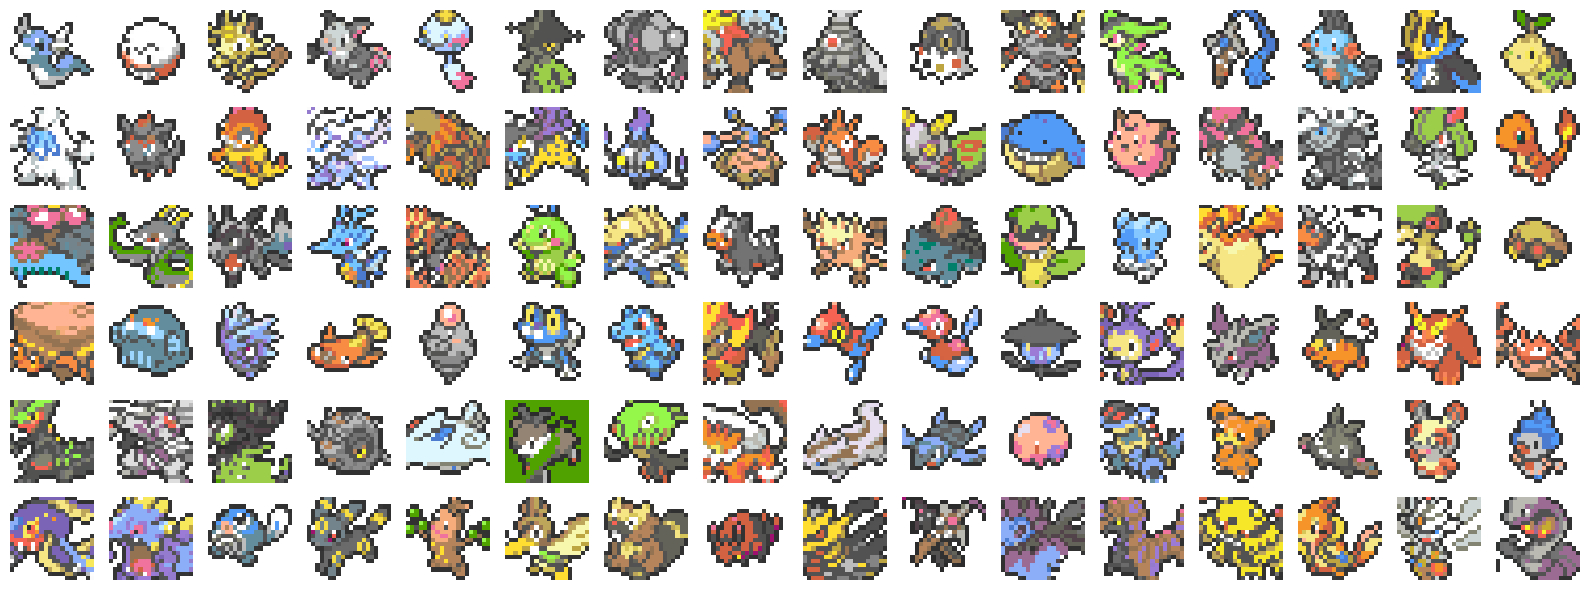

In [55]:
# Visualize generated test images
predicted_images = [pixel_to_image(sequence, colormap) for sequence in results]
show_images(predicted_images)